# FFT saved file test

(256, 32769)
[3.48514938 0.31195973 0.28275299 0.14633775 0.17664176 0.18447331
 0.16629906 0.08810677 0.17808428 0.17624454 0.14265532 0.20673067
 0.30799366 0.14605174 0.11433741 0.17284188 0.19282936 0.19039376
 0.12590683 0.17060212 0.19513233 0.19979359 0.17570655 0.12338177
 0.21034675 0.16104924 0.28655163 0.45400547 0.16203788 0.18971582
 0.17477779 0.15735407 0.17120182 0.19427506 0.18558414 0.09750444
 0.16554963 0.18222589 0.20934957 0.1853768  0.17397457 0.16431404
 0.20063285 0.21289786 0.17289187 0.22312635 0.13120805 0.16306386
 0.149448   0.10362703 0.13184433 0.17697697 0.13285319 0.14213868
 0.09217988 0.15778134 0.17089472 0.15125299 0.170275   0.1628126
 0.11200584 0.11651122 0.09655507 0.18072243 0.17340018 0.14556528
 0.20055706 0.14966757 0.17048302 0.12988544 0.11848726 0.16327993
 0.16802549 0.18952135 0.14401789 0.0978306  0.10501957 0.13569806
 0.1405861  0.11361874 0.1788655  0.15379477 0.11151726 0.16352061
 0.14816175 0.17190872 0.13995486 0.15279273 0.153

/home/gq/projs/adc/python_udp_recv/fft_helper.py:27: RuntimeWarning: divide by zero encountered in log10
  out = 10.*np.log10(np.abs(data/data.size)**2/resistor/mili_power)


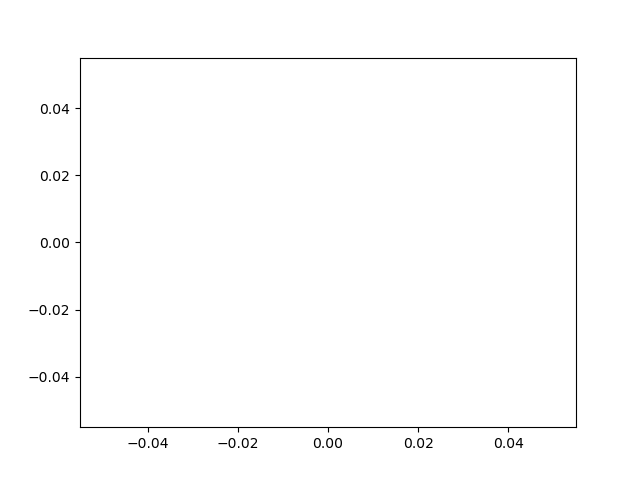

In [64]:
import numpy as np
import h5py as h5
from fft_helper import fft_to_dBm

%matplotlib widget

from numpy.fft import fft,rfft,rfftfreq
import matplotlib.pyplot as plt

fname = './fft_test/2022-03-07/15/RAW_output1_0.h5'

f = h5.File(fname, 'r')

py = f['amplitude'][...]

print(py.shape)

st = 1/480.
px = rfftfreq(4096*16, d=st)

print(py[0,0:100])
plt.plot(px, fft_to_dBm(py[-1,...]))
plt.show()


# GPU FFT test

In [31]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

2022-03-05 16:19:11.111114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 47169 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:7c:00.0, compute capability: 7.5


['/device:GPU:0']

In [4]:
import torch

torchdevice = 0

names =[]

name = 'PyTorch\nGPU'
device_type = 'cuda'
device = torch.device('cuda:{}'.format(torchdevice))
names.append(name)
print('{} available: {}'.format(name, torch.cuda.is_available()))

PyTorch
GPU available: True


In [16]:
import torch
import mkl_fft
def torch_ifft2_fft2(data):
    signal_ndim = 2
    data2 = torch.fft.fft(data)
    return torch.fft.ifft(data2)

def np_ifft2_fft2(data):
    data2 = mkl_fft.fft.fft2(data)
    return mkl_fft.fft.ifft2(data2)

sizes = [512, 1024, 2048, 4096] # X * X pixel arrays/tensors
names = []
totaltimes=[]
name = 'PyTorch\nGPU'
device_type = 'cuda'
device = torch.device('cuda:{}'.format(0))
names.append(name)
print('{} available: {}'.format(name, torch.cuda.is_available()))
torchtimes = []
datas = [torch.randn(size=(x,x,2), device=device) for x in sizes]
print(f'Working on device: {datas[0].device}')
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    t = %timeit -o torch_ifft2_fft2(data)
    torchtimes.append(t)
totaltimes.append(torchtimes)

PyTorch
GPU available: True
Working on device: cuda:0
PyTorch GPU 512x512
26 µs ± 3.19 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
PyTorch GPU 1024x1024
172 µs ± 27.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
PyTorch GPU 2048x2048
678 µs ± 31.3 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
PyTorch GPU 4096x4096
2.7 ms ± 35.6 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
name = 'PyTorch\nCPU'
device_type = 'cpu'
device = torch.device(device_type)
names.append(name)
torchtimes = []
datas = [torch.randn((x,x,2), device=device) for x in sizes]
print(f'Working on device: {datas[0].device}')
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    t = %timeit -o torch_ifft2_fft2(data)
    torchtimes.append(t)
totaltimes.append(torchtimes)

Working on device: cpu
PyTorch CPU 512x512
296 µs ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
PyTorch CPU 1024x1024
533 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
PyTorch CPU 2048x2048
18.1 ms ± 64.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
PyTorch CPU 4096x4096
61.4 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
import numpy as np

name = 'Numpy\nCPU'
names.append(name)
nptimes = []
datas = [np.random.normal(size=(x,x)).astype('complex128') for x in sizes]
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    t = %timeit -o np_ifft2_fft2(data)
    nptimes.append(t)
totaltimes.append(nptimes)

Numpy CPU 512x512
9.3 ms ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Numpy CPU 1024x1024
51 ms ± 36.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Numpy CPU 2048x2048
330 ms ± 412 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy CPU 4096x4096
1.39 s ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
import cupy as cp

def cp_ifft2_fft2(data):
    data2 = cp.fft.fft2(data)
    return cp.fft.ifft2(data2)

name = 'CuPy\nGPU'
names.append(name)
cptimes = []
device = cp.cuda.Device(0)
with device:
    datas = [cp.random.normal(size=(x,x)).astype('complex128') for x in sizes]
    for x, data in zip(sizes, datas):
        print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
        t = %timeit -o cp_ifft2_fft2(data)
        cptimes.append(t)
    totaltimes.append(cptimes)

# # Clear cupy memory
# mempool = cp.get_default_memory_pool()
# del datas
# mempool.free_all_blocks()

CuPy GPU 512x512
216 µs ± 57.5 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CuPy GPU 1024x1024
1.01 ms ± 3.05 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CuPy GPU 2048x2048
3.89 ms ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CuPy GPU 4096x4096
15.8 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
